Перед нами стоит задача выбора потенциально популярной игры для интернет-магазины на основне исторических данных о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Для этого - нужно найти закономерности успеха игры у аудитории. 

Описание данных:
Name — название игры
Platform — платформа
Year_of_Release — год выпуска
Genre — жанр игры
NA_sales — продажи в Северной Америке (миллионы долларов)
EU_sales — продажи в Европе (миллионы долларов)
JP_sales — продажи в Японии (миллионы долларов)
Other_sales — продажи в других странах (миллионы долларов)
Critic_Score — оценка критиков (максимум 100)
User_Score — оценка пользователей (максимум 10)
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
Данные за 2016 год могут быть неполными.

Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats as st
from collections import Counter
from matplotlib.pyplot import figure

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Шаг 2. Подготовьте данные

Приводим названия столбцов датасета к нижнему регистру.

In [3]:
df.columns = map(str.lower, df.columns)

Смотрим, что с пропусками.

In [4]:
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Поехали работать с годом релиза.

In [5]:
df['year_of_release'].value_counts()

2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      62
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
Name: year_of_release, dtype: int64

269 пропущенных значений, по разбросу значений по годам видим, что большинство нужной даты для анализа у нас есть - начиная с 2000-х гг. и с максимальными значениями в 2008 и 2009 гг. Наличие пропусков в столбце с релизами скорее всего связано с каким-нибудь либо техническим аспектом, либо человеческим фактором: если игры вышла, то у неё должен быть год выпуска. Итак, из-за того, что у нас есть более чем достаточное количество данных для анализа - заполняем пропущенные значения нулями.

In [6]:
df['year_of_release'].fillna(0, inplace=True)

In [7]:
df['critic_score'].value_counts()

70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
       ... 
20.0      3
17.0      1
22.0      1
13.0      1
21.0      1
Name: critic_score, Length: 82, dtype: int64

8 576 пропущенных значений. Возможно, это связано с размахом во временном периоде датасета: у нас есть наблюдения, начиная с 1980 года, скорее всего, тогда не было таких институтов в игровой индустрии, которые бы выкатывали рецензии на каждую вышедшую игру (aka промо). Заменяем нулями.

In [8]:
df['critic_score'].value_counts()

70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
       ... 
20.0      3
17.0      1
22.0      1
13.0      1
21.0      1
Name: critic_score, Length: 82, dtype: int64

Смотрим, что с рейтингом.

In [9]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Рейтинг игр ESRB имеет следующую классификацию:

«EC» («Early childhood») — «Для детей младшего возраста»
«E» («Everyone») — «Для всех» (Первоначально "K-A" ("Kids to Adults"))
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
«T» («Teen») — «Подросткам»
«M» («Mature») — «Для взрослых»
«AO» («Adults Only 18+») — «Только для взрослых»
«RP» («Rating Pending») — «Рейтинг ожидается»

K-A и E повторяют друг друга в описании: Kids to adults и Everyone. Соответственно, избавляемся от избыточности. 

In [10]:
df['rating'] = df['rating'].replace('K-A', 'E')

В рейтинге пользователей есть значение tbd - to be declared (=TBA, to be anounced). То есть на момент сбора даты рейтинга от пользователей не было, ставим Nan-ы.

In [11]:
df['user_score']=df['user_score'].replace('tbd',pd.np.nan)

Приводим к нужному типу столбцы с годами выпуска (целые числа), оценка от критиков (так же целые числа) а рейтинг от пользователей приводим от строки к числу.

In [13]:
df['user_score']= pd.to_numeric(df['user_score'])

Смотрим, всё ли сработало.

In [14]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Так, поехали работать дальше с пропусками.

In [15]:
df.isnull().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Пропущенные значения в обнаруженных столбцах я решила заполнить нулями. Для того, чтобы сделать адекватную аналитику по популярным жанрам и платформам - нам не нужны данные (причем еще и отсутствующие из-за отличной конъюнктуры в тогдашнем игровом мире) 30-летней давности (со всем уважением к любителям ретро-приставок, но деньги индустрии находятся не там, а в продажах пятой ГТА, например, на сущетсвующие платформы от Сони, Майкрософта и ещё немного Нинтендо).

Две строки с пропущенными названиями игр и их жанра просто удаляем, скорее всего, ошибка в выгрузке данных: если игра есть, то у неё должен быть определен и жанр. Так как это только два значения, то удаление не повлияет на дальнейший анализ.

In [17]:
df.dropna(subset = ['name'], inplace = True)

Проверка на пропуски:

In [18]:
df.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
dtype: int64

Можно возразить, что заполнить рейтинги от пользователей нулями было бы неверным решением для дальнейшего анализа, однако, я думаю, что главным показателем успеха игры являются её продажи и выручка. Рейтинг пользователей можно рассматривать как крайне субъективную оценку: кому дано шутить в Call of Duty, не дано собирать HP в Final Fantasy и наоборот. В случае же с рейтингом от критиков это можно рассматривать как "кто деньги за публикацию занёс - тот и будет отрецензирован", особенно учитывая капитализацию рынка игр и развития игровых отделов крупнейших игроков в области техники - Сони и Майкрософта. 

Шаг 3. Исследовательский анализ данных.

Итак, нужны ли нам все данные по годам из датасета? Очевидно, нет. Если мы возьмем слишком широкий размах, то дальнейший анализ может быть размыт в точности интерпретации - на меньшей страте анализ будет более адекватный самой сути исследования, а главное - нынешней коньюнктуре рынка. Поэтому беру началом 2000 год.

In [19]:
df_clean= df.query('year_of_release > 2000')

Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец.

In [20]:
df_clean['total_sales'] = df_clean['na_sales'] + df_clean['eu_sales'] + df_clean['jp_sales'] + df_clean['other_sales']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


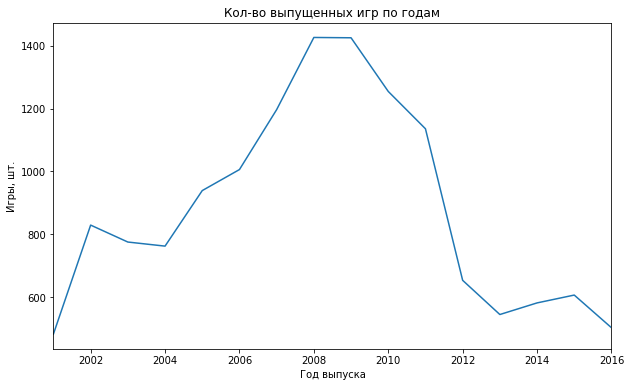

In [21]:
count_by_year = df_clean.groupby('year_of_release')['name'].count()
count_by_year.plot(figsize=(10, 6), title='Кол-во выпущенных игр по годам')
ax = plt.gca()
ax.set_ylabel('Игры, шт.')
ax.set_xlabel('Год выпуска');

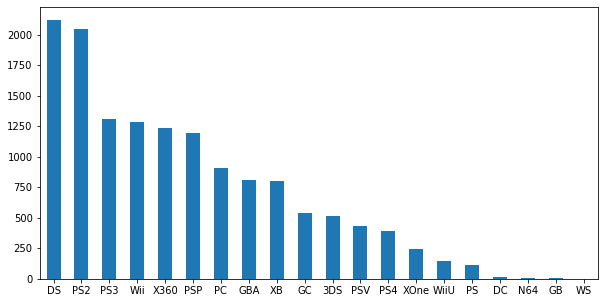

In [22]:
df_clean['platform'].value_counts().plot(kind='bar',figsize=(10,5),rot=0);

In [23]:
df_clean['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS2', 'GBA', 'PS4', '3DS', 'XB', 'PC',
       'PSP', 'XOne', 'WiiU', 'GC', 'PS', 'PSV', 'GB', 'N64', 'DC', 'WS'],
      dtype=object)

In [24]:
category_platform = {'Wii':'Nintendo','NES':'Nintendo','GB':'Nintendo','DS':'Nintendo','X360':'Xbox','PS3':'PS','PS2':'PS','SNES':'Nintendo','GBA':'Nintendo'
                                ,'PS4':'PS','3DS':'Nintendo','N64':'Nintendo','PS':'PS','XB':'Xbox','PC':'PC','2600':'Atari','PSP':'PS','XOne':'Xbox'
                                ,'WiiU':'Nintendo','GC':'Nintendo','GEN':'Other','DC':'DC','PSV':'SP','SAT':'SAT','SCD':'PC','WS':'Box Game','NG':'Nintendo'
                                ,'TG16':'PC','3DO':'Other','GG':'Other','PCFX':'PC'}

In [25]:
Counter(category_platform.values()).most_common()

[('Nintendo', 11),
 ('PS', 5),
 ('PC', 4),
 ('Xbox', 3),
 ('Other', 3),
 ('Atari', 1),
 ('DC', 1),
 ('SP', 1),
 ('SAT', 1),
 ('Box Game', 1)]

In [26]:
df['platform_category'] = df['platform'].replace(category_platform)

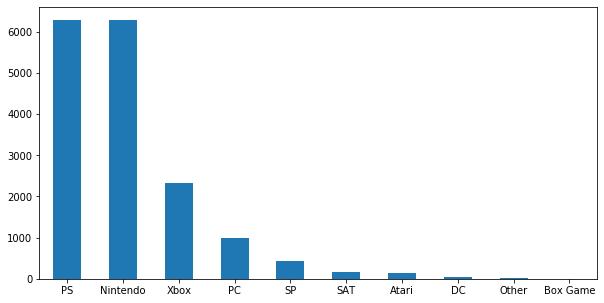

In [27]:
df['platform_category'].value_counts().plot(kind='bar',figsize=(10,5),rot=0);

Видим, что по платформам лидируют Sony и Nintendo. С Nintendo нужно учитывать, что у них широчайшая линейка портативных консолей и других, в то время как у Sony в датасете представлены только четыре поколения одной и той же PlayStation. У Microsoft вообще же представлены только три версии их консоли. Плюс, если еще углубляться, то разумнее, конечно, было бы сравнивать не вообще всю линейку Nintendo с другими платформами, а брать именно Wii, выпущенную в 2006 году как конкурента Xbox360 и PS3, это было бы соразмернее, т.к. эти три платформы от гигантов боролись за один и тот же рынок, оперируя в поле схожих технических характеристик.

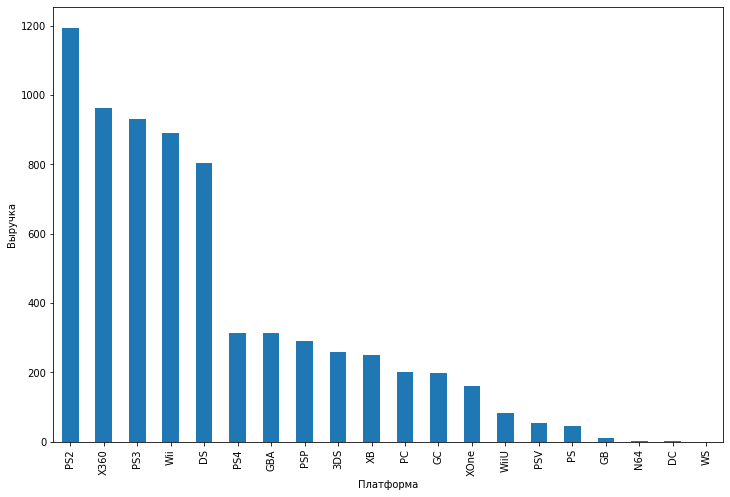

In [28]:
((df_clean.pivot_table(index='platform', values='total_sales', aggfunc='sum')
         .sort_values('total_sales', ascending=False))
   .plot(kind='bar', y='total_sales', figsize=(12, 8), legend=False)
            .set(xlabel='Платформа', ylabel='Выручка'))
plt.show()

Собственно, по этому графику можно и увидеть подтверждение выше сказанного: Nintendo сражается за свой кусок рынка с платформой Wii. Плюс, те же нинтендовские DS или GameBoy не могут попадать в ту же категорию, что Wii, Xbox360 и PS - это просто очень разные платформы хотя бы по техническим показателям, и можно сказать, что аудитории первых в большинстве своем не пересекаются со вторыми. Если забегать немного вперед и пользоваться знанием нынешнего рынка, то можно привести такое наблюдение: новой ставкой Nintendo стал Switch, эдакий синтез Wii, DS и GameBoy - портативный экран, неплохие технические характеристики. Однако, для Switch нет соответствующей версии Call of Duty (но для справделивости упомянем наличие Wolfenstein 2 для Switch'а). Т.е. Nintendo - это больше про Animal Crossing и спортивные жанры (эта часть утверждения касается больше прошлого времени, когда Wii выкатил котроллеры эмулировавшие движения игрока, тем самым открывая возможность спортивного погружения).

Поехали смотреть топ платформ по выручке.

In [29]:
df_clean.groupby('platform')['total_sales'].sum().sort_values(ascending=False)


platform
PS2     1194.39
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS4      314.14
GBA      312.81
PSP      289.53
3DS      257.81
XB       250.58
PC       201.06
GC       196.73
XOne     159.32
WiiU      82.19
PSV       53.81
PS        44.33
GB         9.24
N64        3.33
DC         1.42
WS         0.28
Name: total_sales, dtype: float64

Так как графики будут однотипными, то пишем функцию для их выполнения. 

In [30]:
def plot_bar(df,x,y,column='',value='',func='sum'):
    if column != '' and value != '':
        df_clean = df[df[column] == value]
        plot_df = df_clean.pivot_table(index=x,values=y,aggfunc=func)
        values_to_plot = plot_df[y].values
    else:
        plot_df = df_clean.pivot_table(index=x,values=y,aggfunc=func)
        values_to_plot = plot_df[y].values
        
    ax= plot_df.plot(kind='bar',figsize=(12,6),rot=45,title=value,legend=False)

    for i, v in enumerate(values_to_plot):
        ax.text(i,v + 3, str(round(v)), fontweight='bold')

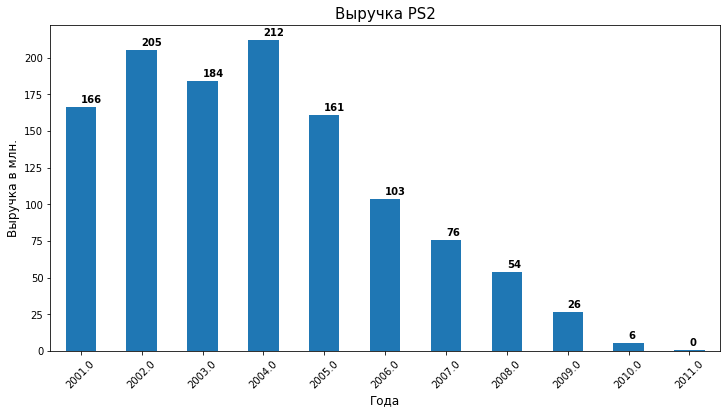

In [31]:
plot_bar(df_clean,'year_of_release','total_sales','platform','PS2')
plt.title('Выручка PS2', fontsize=15)
plt.xlabel('Года', fontsize=12)
plt.ylabel('Выручка в млн.', fontsize=12);

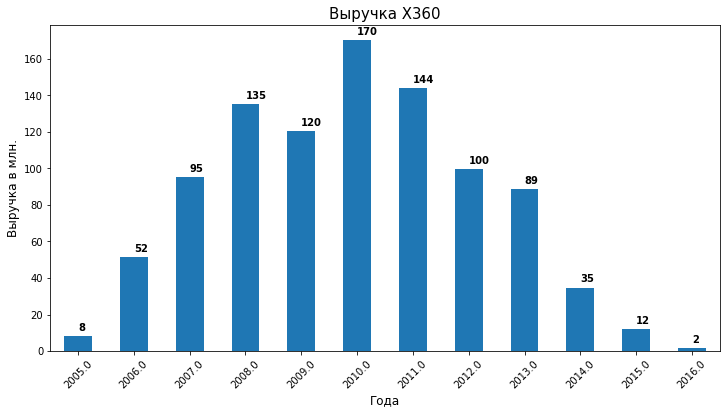

In [32]:
plot_bar(df_clean,'year_of_release','total_sales','platform','X360')
plt.title('Выручка X360', fontsize=15)
plt.xlabel('Года', fontsize=12)
plt.ylabel('Выручка в млн.', fontsize=12);

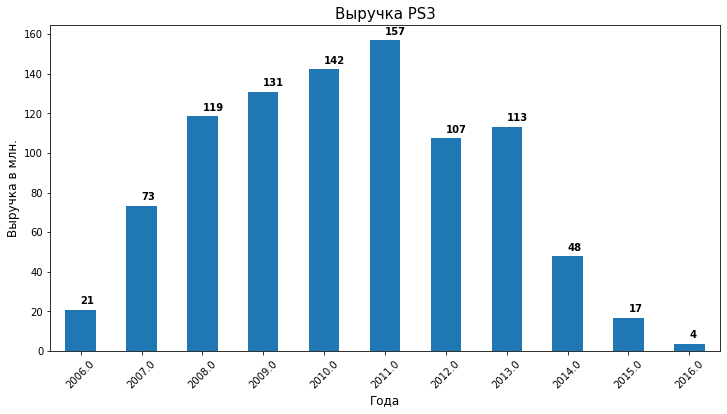

In [33]:
plot_bar(df_clean,'year_of_release','total_sales','platform','PS3')
plt.title('Выручка PS3', fontsize=15)
plt.xlabel('Года', fontsize=12)
plt.ylabel('Выручка в млн.', fontsize=12);

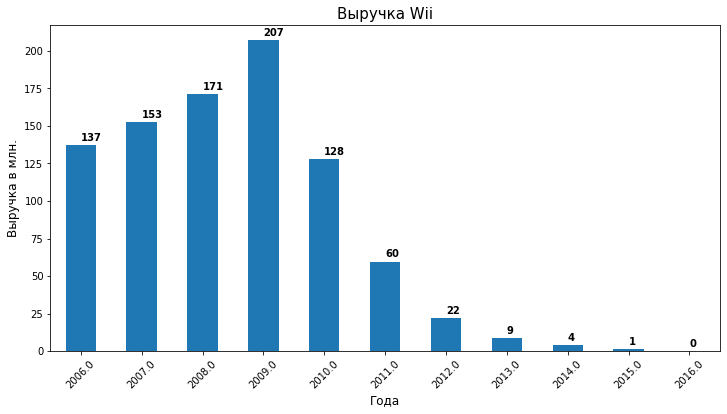

In [34]:
plot_bar(df_clean,'year_of_release','total_sales','platform','Wii')
plt.title('Выручка Wii', fontsize=15)
plt.xlabel('Года', fontsize=12)
plt.ylabel('Выручка в млн.', fontsize=12);

Я построю также график для PS4, "но ведь показатели не входит в топ" - можно возразить, однако четвёртая плойка вышла только в 2013 году, у неё просто не было такого цикла жизни, как у той же третьей плойки, например, однако, это была флагманская консоль, и игры с рейтингом ААА релизились на ней. Причём, по выручке она бодро обгоняет своего конкурента из того же 2013 года Xbox One - 315 против 160, почти в два раза.

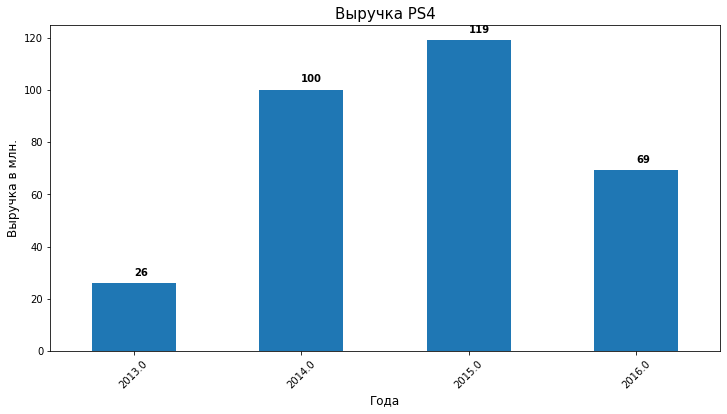

In [35]:
plot_bar(df_clean,'year_of_release','total_sales','platform','PS4')
plt.title('Выручка PS4', fontsize=15)
plt.xlabel('Года', fontsize=12)
plt.ylabel('Выручка в млн.', fontsize=12);

Отвечая на вопрос "За какой характерный срок появляются новые и исчезают старые платформы?", я просто обращусь к доступной всем информации по выпускам консолей. У Майкрософта цикл выглядит так: 2001/2005/2013. У Сони (не беру PS 1994 года): 2000/2006/2013. Нинтендо 2006/2012 (Wii/WiiU) Выходит 4 и 8 лет, 6 и 7 лет, 6 лет; считаем среднее арифметическое - 6.2 лет требуется для появления новой платформы (и, добавим, создания игр-блокбастеров, что будут драйвить продажи консоли). 

Какие платформы лидируют по продажам, растут или падают? Потенциально прибыльными платформами можно считать те платформы, которые являются самым свежим выпуском в поколнии консоли: лучшие технические характеристики, которые можно предложить разработчкам, пользователям; игры с рейтингом ААА, которые выходят на новых консолях, поэтому можно смело сказать, что продуктивными в плане выручки будут консоли PS4 и Xbox One. Включить в этот лайнап WiiU не представляется возможным, так как по выручке она очень сильно уступает, что Сони, что Майкрософту - 314/160/82 соответственно. Можно сказать, что именно в тот момент стали понятно, какие два производителя консолей будут доминировать на рынке, и в этот ряд Nintendo не входит (но у них безусловно есть своя ниша аудитории). 

Построим боксплот по глобальным продажам игр в разбивке по платформам.

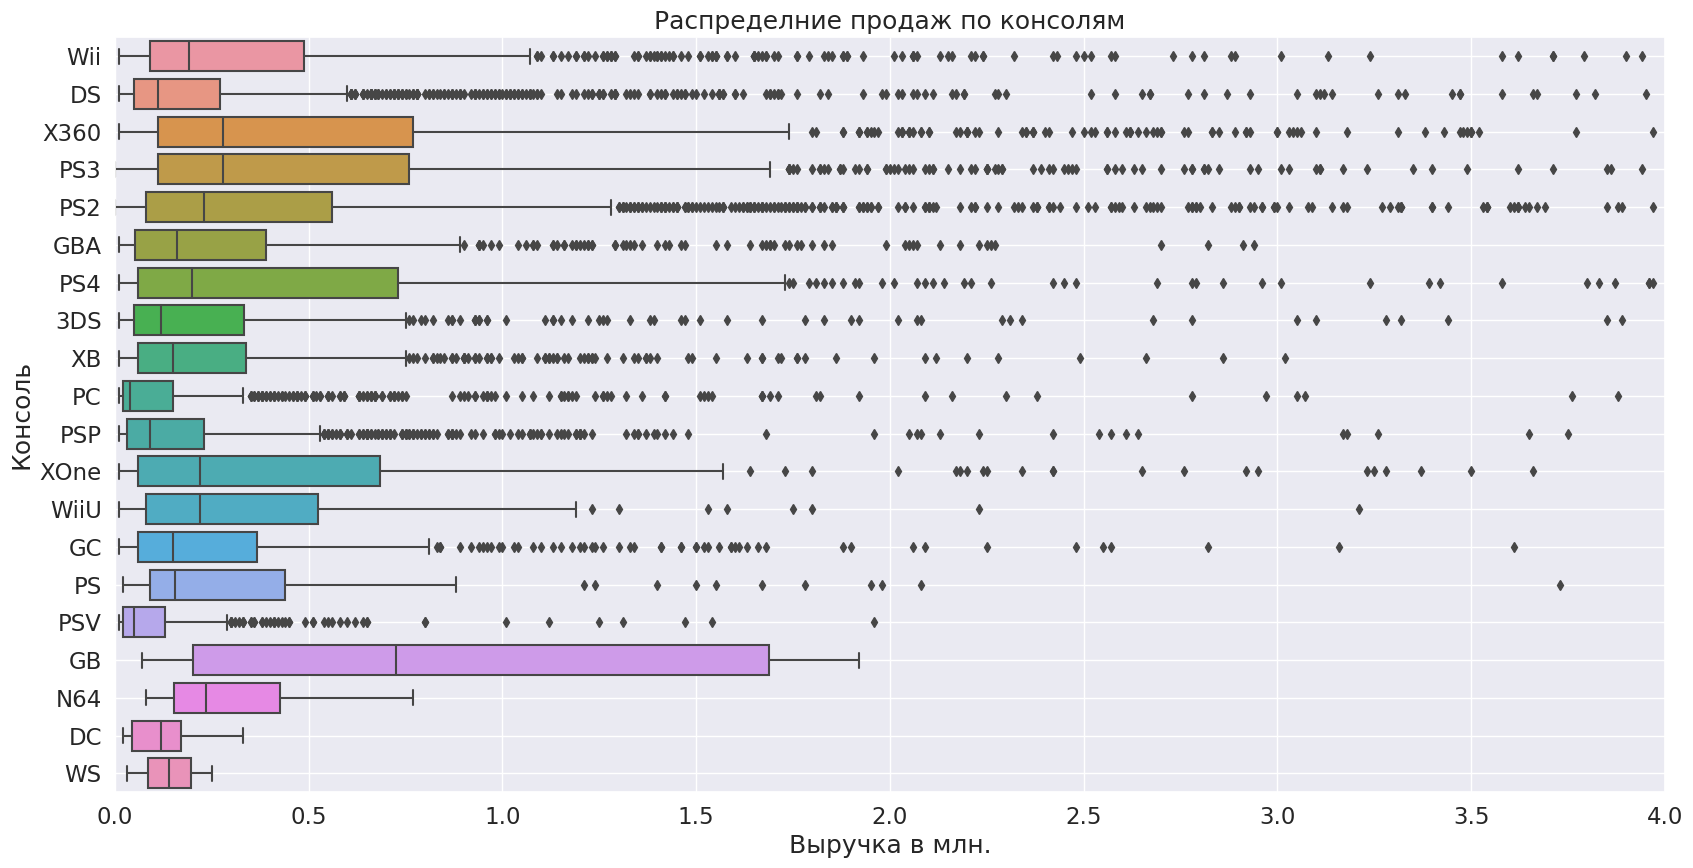

In [36]:
figure(figsize=(20,10),dpi=100)
sns.set(font_scale = 1.5)
chart=sns.boxplot(x='total_sales', 
             y='platform', 
             data=df_clean,orient='h')
chart.grid(True)
chart.set(xlim=(0,4))
plt.xlabel("Выручка в млн.")
plt.ylabel("Консоль")
plt.title("Распределние продаж по консолям")
plt.show()

Так, вижу какую-то странную вещь, а именно - у GB что-то около 1.7 млн. выручки и он резво обгоняет другие платформы. Окей, посмотрим на это с другой стороны. Построю гистрограмму ещё раз.

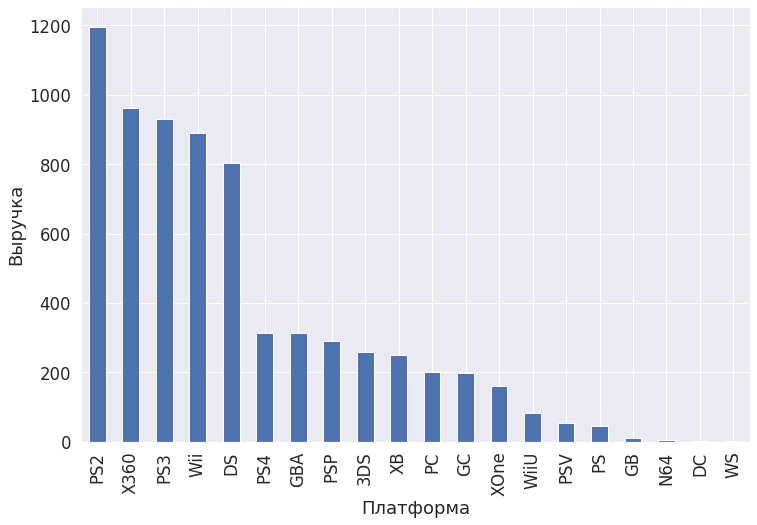

In [37]:
((df_clean.pivot_table(index='platform', values='total_sales', aggfunc='sum')
         .sort_values('total_sales', ascending=False))
   .plot(kind='bar', y='total_sales', figsize=(12, 8), legend=False)
            .set(xlabel='Платформа', ylabel='Выручка'))
plt.show()

На гисте всё корректно. Не могу понять, почему на боксплоте тогда отображается по-другому, несмотря на одни и те же входные данные. Буду интерепритировать данные с гистограммы. Итак, по общей выручке лидируют консоли прошлого поколения, но это только из-за более долгого цикла жизни и существования на рынке по сравнению с новым поколением. 

Посмотрим, как влияют на продажи отзывы критиков и пользователей, построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [38]:
ps4 = df_clean.query("platform == 'PS4'")
xone = df_clean.query("platform == 'XOne'")

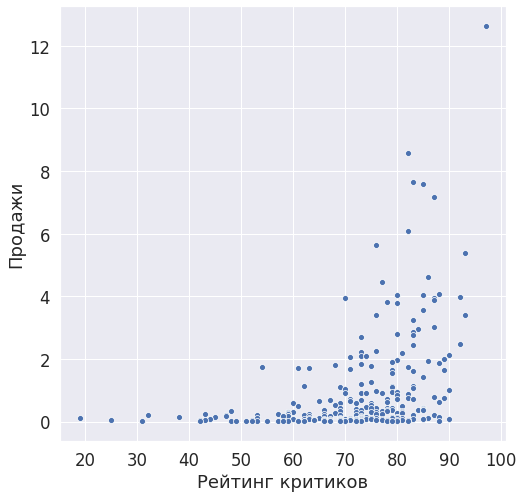

In [39]:
figure(figsize=(8,8))
ax=sns.scatterplot(x='critic_score',y='total_sales',data=ps4, alpha=1)
ax.set(xlabel='Рейтинг критиков',ylabel='Продажи')
plt.show()

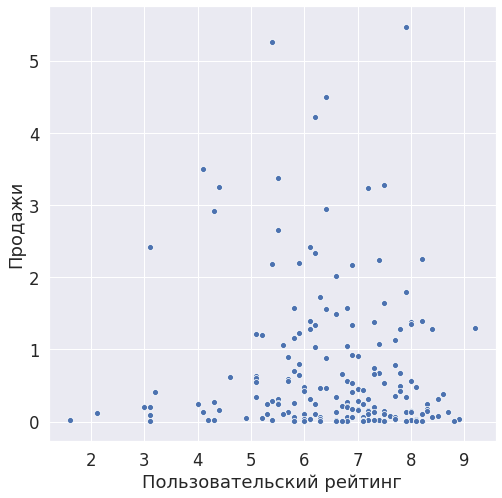

In [41]:
figure(figsize=(8,8))
ax=sns.scatterplot(x='user_score',y='total_sales',data=xone, alpha=1)
ax.set(xlabel='Пользовательский рейтинг',ylabel='Продажи')
plt.show()

In [42]:
corr = df_clean[['critic_score', 'user_score', 'total_sales']].corr()
corr.style.format("{:.2%}")

,critic_score,user_score,total_sales
critic_score,100.00%,57.53%,23.81%
user_score,57.53%,100.00%,8.03%
total_sales,23.81%,8.03%,100.00%


<b>UPD: <font color='green'>Хорошо.И по графикам это также видно. Действительно, причинно-следственная связь не всегда очевидна, зачастую это предмет отдельного исследования. 

Можно сказать, что причинно-следственной связи между отзывами и продажами игр нет: да, продажи могут быть на процент выше при высоком рейтинге от критиков, но по диаграмме можно увидеть, что это совсем не тенденция. Просто есть жанры, скажем так пути игрока-пользователя, которые он эксплойтит, и как у любого человека с эмпатией, игрок будет выбирать одну и ту же игру просто новой версии на новой консоли, например. То есть, сказывается человеческая привязанность ("Ностальгия продаётся") игрока к игре. 

Поехали смотреть, что там по жанрам.

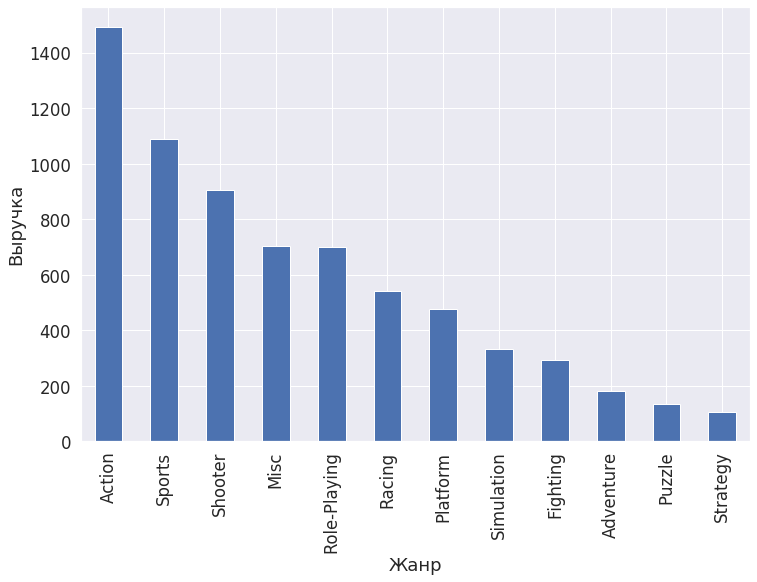

In [43]:
((df_clean.pivot_table(index='genre', values='total_sales', aggfunc='sum')
         .sort_values('total_sales', ascending=False))
   .plot(kind='bar', y='total_sales', figsize=(12, 8), legend=False)
            .set(xlabel='Жанр', ylabel='Выручка'))
plt.show()

Погуглив, узнаём, что такое Misc как категория жанра: Casual Game, Programming Game (нойс!), Logic Game, Music Game, Party Game, Trivia Game, Board Game/Card Game. Наверно, такой жанр можно описать как игры, которые могут быть как одиночными, так и социальными, не требует от игрока уровень пользования контроллером "Бог" и вообще подразумевают leisure activities. Первое место забирает жанр Action (наверно стоит упомянуть, что прям совсем чистых жанров в игровой индустрии нет, всё равно это синтез нескольких), второе - Sports, третье - шутеры, четвёртое - Misc и пятое - RP. Замыкают весь список топа по выручке - стратегии и паззлы. Про стратегии хотела бы озувчить догадку, почему этот жанр так просел: ведь были золотые времена стратегии, когда все славно рубили в "Казаков", "Tropico" и "Age of Empires". Скорее всего, спад связан с расцветом консолей, всё-таки стратегии это больше про ламповый ПК, наличие мыши и кружки с чаем. Играть в стратегию через контроллер дело непривычное и наверно не самое разумное чисто с точки зрения эргономики. 

Шаг 4. Портрет пользователя по регионам - North American, Europe, Japan

Топ-5 популярных консолей в каждом регионе:

In [44]:
df_act= df.query('year_of_release > 2013')

In [45]:
regions = ['na_sales','eu_sales','jp_sales']

for region in regions:
    display(df_act.pivot_table(index='platform',values=region,aggfunc='sum')\
                        .sort_values(by=region,ascending=False).head())
    

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


Японцы покупают своё и счастливы, доминирует Nintendo. Европейцы пока не обновили консоли до версий последних поколений, что от Сони, что от Майка (консервативность старушки Европы? Вполне). И лидеры по продажам юнитов - Северная Америка, с бОльшей поддержкой своего производителя - X 360, чуть ниже идёт PS2.

Посмотрим, что с топом жанров:

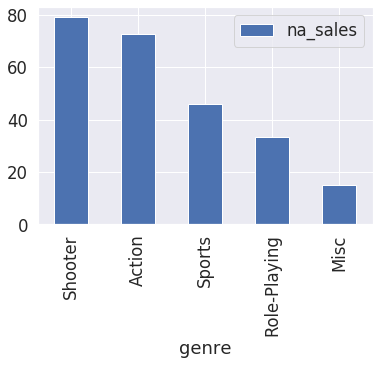

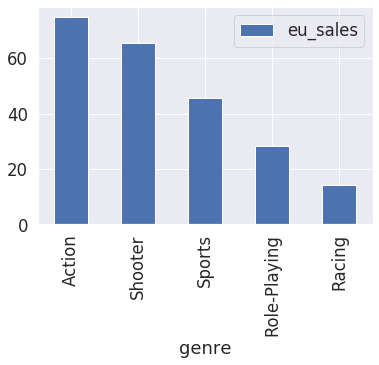

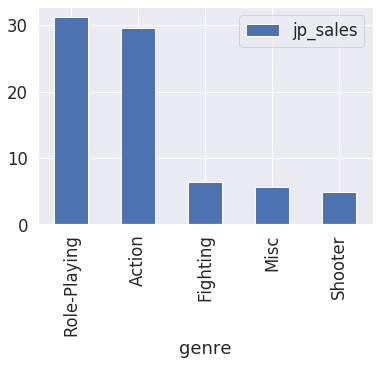

In [46]:
df_act.groupby(by='genre').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head(5).plot(kind='bar')
df_act.groupby(by='genre').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='bar')
df_act.groupby(by='genre').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='bar');

Европейская и американская части мира сходятся во вкусах к RP и Sports жанрам - третье и четвёртое место соответственно, американцы же больше любит шУтить, а потом экшонить, а европейцы - ровно наоборот. Японцы, следуя давней традици, преподчитают жанр RP (вот уж кто любит нарратив в играх, и где-то пишет новую новеллу Кодзима), не сильно отстает и жанр Action, далее - сильное затухание и третье место с файтинг играми.

Влияет ли рейтинг ESRB на продажи в отдельном регионе:

In [49]:
df_clean.groupby('rating')['na_sales','eu_sales','jp_sales'].agg(['median','mean']).sort_values(by=['AO','E','T','M','EC','E10+'], axis=1)

jp_sales           eu_sales           na_sales          
         median      mean   median      mean   median      mean
rating                                                         
AO          0.0  0.000000     0.61  0.610000    1.260  1.260000
E           0.0  0.049308     0.03  0.177825    0.120  0.322593
E10+        0.0  0.028879     0.03  0.131703    0.120  0.248204
EC          0.0  0.000000     0.00  0.013750    0.155  0.191250
M           0.0  0.037905     0.09  0.312109    0.140  0.481346
RP          0.0  0.000000     0.03  0.030000    0.000  0.000000
T           0.0  0.043687     0.04  0.135062    0.100  0.245468

'E'=Все, 'AO'=Взрослые18+, 'M'=17+, 'T'=страше 13+, 'E10+'=10+ , 'EC'=дети

Судя по всему, рейтинг просто делает более широкой потенциальную аудитории игры (плюс, которая ещё может позволить себе её купить, то есть, имеет собственный доход), поэтому и лидирует маркировка "18+" в продажах. 

Шаг 5. Проверяем гипотезы

H0: средний пользовательский рейтинг платформ PC и XOne одинаковый
H1: средний пользовательский рейтинг платформ PC и XOne различается

In [ ]:
alpha = 0.05

In [ ]:
pc = df_act[(df_clean['platform'] == 'PC') & (df_clean['user_score'] > 0)]['user_score']
xone = df_act[(df_clean['platform'] == 'XOne') & (df_clean['user_score'] > 0)]['user_score']

In [ ]:
results = st.ttest_ind(pc, xone)

In [ ]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Альтернативная гипотеза")
else:
    print("Нулевая гипотеза")

Выходит, что средний рейтинг от пользователей на платформах PC и XOne - разнятся.

H0: средний пользовательский рейтинг жанров Action и Sports одинаковый
H1: средний пользовательский рейтинг жанров Action и Sports различается

In [ ]:
action = df_act.query("genre == 'Action'")
sports = df_act.query("genre == 'Sports'")

results = st.ttest_ind(
    action['user_score'],
    sports['user_score'],
    nan_policy='omit' 
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Альтернативная гипотеза")
else:
    print("Нулевая гипотеза")

Придерживаемся утверждения, что средний пользовательский рейтинг жанров Action и Sports различается.

Шаг 6. Общие выводы

Среднее время жизни консоли в одном поколении - 6.2 года, за это время проивзодители успевают выкатить новое поколение, а разработчики - игры-драйверы, что будут пушить продажи юнитов. Также, можно сказать, что цикла такой длины хватает для эффекта новизны, далее - нужно меняться. Если углубиться немного в детали, то можно отметить, что Сони в третьем поколении PS делала три итерации - PS3, PS3 Slim и PS3 Super Slim. Интерес к платформе стоит поддерживать какими-нибудь выпусками модификаций внешнего вида. Ставку стоит делать на игры с маркировкой "18+", что логично - кто платит деньги, тот и заказывает музыку. Топовыми жанрами являются экшн и шутеры, особенно это стоит учитывать, держа в уме тенденцию на фильмизацию игр: где пользователю достаточно проделать пару нехитрых операций до следующей cut scene, и так далее - то есть, по сути, это не игра, а фильм с элементами игры. Таких данных не было в датасете, но понятно, что в экшн-играх примерно один и тот же движок, и управление героем - стандартно, поэтому во время рекламной кампании игры упор стоит делать на нарратив игры, искать якорные точки у потенциальной аудитории и давить на них. 

"Спасибо, что дочитали до конца!"